# Uncertainty analysis 

Outline
- from the particle level locations, call resampleConfiguration to generate a new configuration
  using the estimated location uncertainty for each particle 
- Compute the strain across several resampled configurations. 
- compare that distribution to
    - Guassian function, best fit sense 
    - measured strain across two time points shifted back to zero mean. 

In [15]:
import sys
sys.path.extend(['/Users/zsolt/Colloid_git/TractionRheoscopy'])

from data_analysis import static as da
from data_analysis import uncertaintyAnalysis as ua

import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from importlib import reload
from scipy.stats import norm

### load data

In [6]:
hdf_stem = '/Users/zsolt/Colloid/DATA/tfrGel10212018x/tfrGel10212018A_shearRun10292018f/locations_stitch/'
sed_fName = 'tfrGel10212018A_shearRun10292018f_sed_stitched.h5'
#sedPos = da.loadData2Mem(hdf_stem + sed_fName)
sedPos = pd.read_hdf(hdf_stem + 'tfrGel10212018A_shearRun10292018f_sed_stitched_pandas.h5')
sedStrain_traj_dt1 = pd.read_hdf(hdf_stem + 'tfrGel10212018A_shearRun10292018f_sed_strainTraj_consecutive.h5')

## What is the distribution of uncertainties? 

In [662]:
def px2Micron(coord, label): 
    px2Micron = {'x':0.115, 'y':0.115, 'z': 0.15}
    return coord*px2Micron[label]
    #return xyz_tuple[0]*0.115, xyz_tuple[1]*0.115, xyz_tuple[2]*0.15
def totalSigma(x,y,z): return np.sqrt(x**2 + y**2 + z**2)

In [639]:
pos_t0 = sedPos.xs(0,level='frame')[['x_std','y_std','z_std']]
pos_t0['dx um'] = pos_t0.apply(lambda x: px2Micron(x['x_std'],'x'),axis=1)
pos_t0['dy um'] = pos_t0.apply(lambda x: px2Micron(x['x_std'],'y'),axis=1)
pos_t0['dz um'] = pos_t0.apply(lambda x: px2Micron(x['x_std'],'z'),axis=1)
pos_t0

,x_std,y_std,z_std,dx um,dy um,dz um
particle,,,,,,
0,0.160625,0.149919,0.139626,0.018472,0.018472,0.024094
1,0.121123,0.120859,0.108598,0.013929,0.013929,0.018168
2,0.130098,0.134635,0.117372,0.014961,0.014961,0.019515
3,0.110703,0.114330,0.101162,0.012731,0.012731,0.016605
4,0.134831,0.134550,0.121837,0.015506,0.015506,0.020225
...,...,...,...,...,...,...
966616,0.099691,0.100281,NaN,0.011464,0.011464,0.014954
966617,0.123673,0.123971,0.142448,0.014222,0.014222,0.018551
966618,NaN,NaN,NaN,NaN,NaN,NaN


In [667]:
dx = pos_t0['dx um'].to_numpy()
dy = pos_t0['dy um'].to_numpy()
dz = pos_t0['dz um'].to_numpy()
pos_t0['total sigma (um)'] = np.sqrt(dx**2 + dy**2 + dz**2)
pos_t0

,x_std,y_std,z_std,dx um,dy um,dz um,total sigma (um)
particle,,,,,,,
0,0.160625,0.149919,0.139626,0.018472,0.018472,0.024094,0.035538
1,0.121123,0.120859,0.108598,0.013929,0.013929,0.018168,0.026798
2,0.130098,0.134635,0.117372,0.014961,0.014961,0.019515,0.028784
3,0.110703,0.114330,0.101162,0.012731,0.012731,0.016605,0.024493
4,0.134831,0.134550,0.121837,0.015506,0.015506,0.020225,0.029831
...,...,...,...,...,...,...,...
966616,0.099691,0.100281,NaN,0.011464,0.011464,0.014954,0.022056
966617,0.123673,0.123971,0.142448,0.014222,0.014222,0.018551,0.027362
966618,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/Users/zsolt/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:200: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  line, = ax.plot(a.mean(), 0)
No handles with labels found to put in legend.


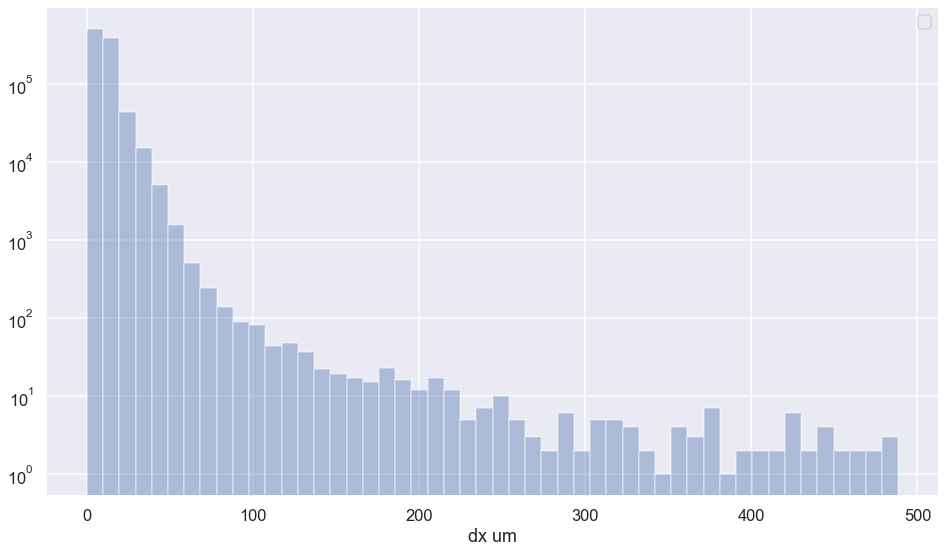

In [772]:
f,ax = plt.subplots(figsize=(16,9))
ax.set(yscale='log')
sns.distplot(1000*pos_t0[pos_t0['dx um'] < 0.5]['dx um'],kde=False, norm_hist=False)
g.set(xlim=(0,3))
plt.legend()

In [658]:
# cumulative distribution
res = scipy.stats.cumfreq(pos_t0[pos_t0['dx um'] < 0.5]['dx um'],numbins=200)

In [659]:
# how many particles have nan value in any of the coordinates

In [720]:
# how many particles have rms location uncertainty less than: 0.1%, 0.5%, 1% and 5% of the diameter? 
diam = 1.5 # diameter in microns 
n_NAN = pos_t0['total sigma (um)'].isna().sum()
N_total = pos_t0['total sigma (um)'].count()
#threshList = np.array([0.001, 0.005, 0.0075, 0.0085, 0.0095, 0.01, (0.0125+0.01)/2, 0.0125, (0.015 + 0.0125)/2, 0.015, 0.02, 0.025, 0.03, 0.05])
#threshList = np.logspace(-3,-1,100)
threshList = np.linspace(0.001,0.05,100)
n_thresh_val = np.array([pos_t0[pos_t0['total sigma (um)'] < thresh*diam]['total sigma (um)'].count() for thresh in threshList])
len(n_thresh_val/n_thresh_val[-1])
len(threshList)
10*threshList

array([0.01      , 0.01494949, 0.01989899, 0.02484848, 0.02979798,
       0.03474747, 0.03969697, 0.04464646, 0.04959596, 0.05454545,
       0.05949495, 0.06444444, 0.06939394, 0.07434343, 0.07929293,
       0.08424242, 0.08919192, 0.09414141, 0.09909091, 0.1040404 ,
       0.1089899 , 0.11393939, 0.11888889, 0.12383838, 0.12878788,
       0.13373737, 0.13868687, 0.14363636, 0.14858586, 0.15353535,
       0.15848485, 0.16343434, 0.16838384, 0.17333333, 0.17828283,
       0.18323232, 0.18818182, 0.19313131, 0.19808081, 0.2030303 ,
       0.2079798 , 0.21292929, 0.21787879, 0.22282828, 0.22777778,
       0.23272727, 0.23767677, 0.24262626, 0.24757576, 0.25252525,
       0.25747475, 0.26242424, 0.26737374, 0.27232323, 0.27727273,
       0.28222222, 0.28717172, 0.29212121, 0.29707071, 0.3020202 ,
       0.3069697 , 0.31191919, 0.31686869, 0.32181818, 0.32676768,
       0.33171717, 0.33666667, 0.34161616, 0.34656566, 0.35151515,
       0.35646465, 0.36141414, 0.36636364, 0.37131313, 0.37626

[Text(0, 0.5, 'Fraction of total particles')]

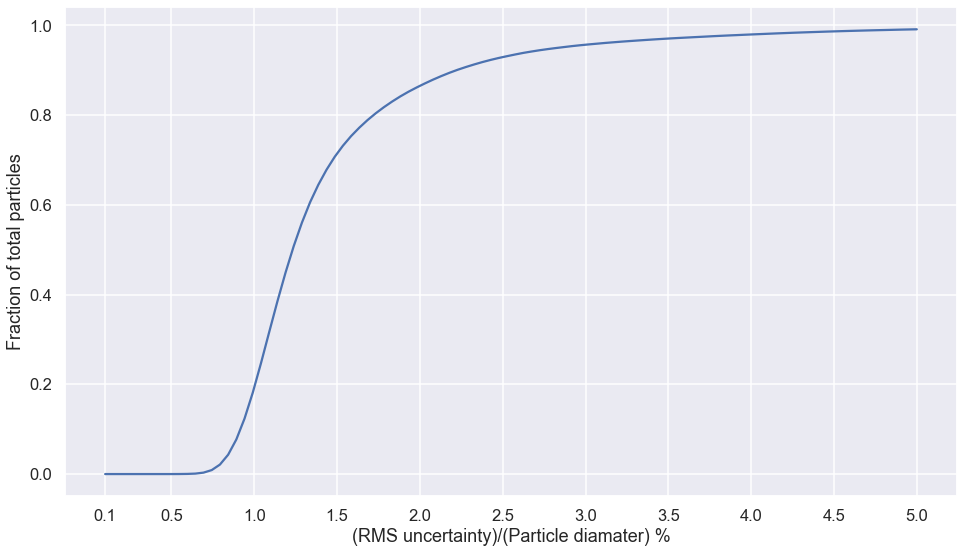

In [997]:
f,ax = plt.subplots(figsize=(16,9))
#ax.set(xscale='log')
ax.set_xticks([0.1, 0.5,1, 1.5, 2, 2.5, (3.5+2.5)/2, 3.5, 4, 4.5, 5])
#ax.set(yscale='log')
g = sns.lineplot(x=100*threshList, y=n_thresh_val/N_total)
g.set(xlabel='(RMS uncertainty)/(Particle diamater) %')
g.set(ylabel="Fraction of total particles")

In [998]:
# what's the spatial distribution of, say, only particle with more than 4% relative uncertainty including NAN?
idx = pos_t0[pos_t0['total sigma (um)'] < 0.015*diam].index
tmp = sedPos.xs(0,level='frame').loc[idx]
tmp

,"x (um, imageStack)","y (um, imageStack)","z (um, imageStack)",x_std,y_std,z_std
particle,,,,,,
7,44.126902,3.408961,27.366915,0.094744,0.093202,0.098060
16,38.453541,6.019379,27.230737,0.094690,0.095585,0.083290
17,46.265660,6.286268,27.300796,0.095155,0.098262,0.092702
24,31.143705,7.301540,27.442166,0.088655,0.087240,0.082698
30,42.114843,9.207295,27.337181,0.095508,0.096470,0.094988
...,...,...,...,...,...,...
966594,195.093354,194.135591,84.147514,0.086633,0.077956,NaN
966611,192.962719,212.016256,69.874427,0.089947,0.092212,0.089670
966614,200.872221,195.003562,77.325691,0.097037,0.093481,0.099537


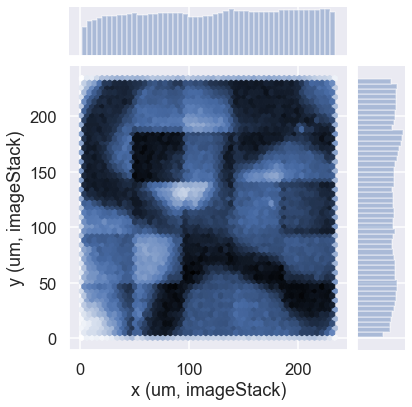

In [999]:
sns.jointplot(x=tmp['x (um, imageStack)'], y=tmp['y (um, imageStack)'], kind ='hex')

## Error Chain monte carlo sampling

Basic idea is to generate new configuration from the estimated uncertainties per particle and use those samples to infer uncertainties in derive quantities like strain assuming locating uncertainty is the dominant source of error. 
Relevant questions:
What is the uncertainty of the strain component of a specificed particle?
What is the distribution of strains in the sample?
What is the distribution of strains that can be attributed only to particle locating uncertainties? I

### resample positions 100x

In [224]:
sedPos0_resampled = ua.resampleConfig(sedPos.xs(0,level='frame').dropna(),N_samples=13)

In [803]:
# select only low error particles
idx_1_5pct = pos_t0[pos_t0['total sigma (um)'] < 0.015*diam].dropna().index
idx_1_5pct
sedPos0_resampled.xs(1,level='frame').loc[idx_1_5pct]

,"x (um, imageStack)","y (um, imageStack)","z (um, imageStack)"
particle,,,
7,44.129083,3.398731,27.364620
16,38.461275,6.037462,27.235580
17,46.242676,6.278909,27.283729
24,31.139885,7.290338,27.439335
30,42.104133,9.197203,27.324524
...,...,...,...
966543,197.080798,220.275254,83.457772
966562,201.558450,205.859393,84.275835
966578,188.705062,233.541003,82.756819


### compute strain

In [225]:
resampled_traj = da.makeLocalStrainTraj(sedPos0_resampled,list(zip([n-1 for n in range(2,12)],[n for n in range(2,12)])))

In [812]:
# compute the strain on **only** particles with lower than 1.5% relative uncertainty
idx_15pct_Multi = pd.MultiIndex.from_product([[x for x in range(14)],idx_1_5pct],names=['frame','particle'])
#sedPos0_resampled.loc[idx_15pct_Multi]
resampled_traj_idx_1_5pct = da.makeLocalStrainTraj(sedPos0_resampled.loc[idx_15pct_Multi],list(zip([n-1 for n in range(2,5)],[n for n in range(2,5)])))

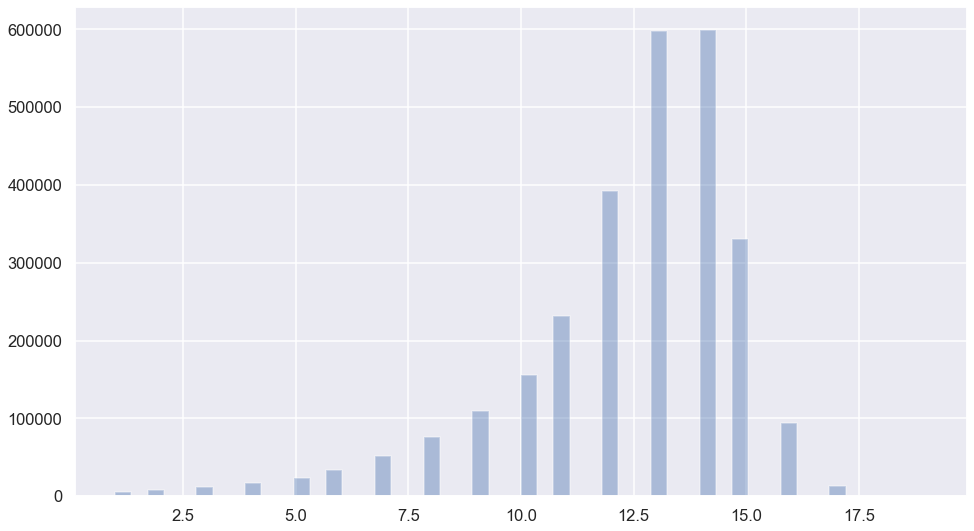

In [818]:
# plot nnb counts as distribution
sns.distplot(resampled_traj_idx_1_5pct.loc[(slice(None),'nnb count'),:].to_numpy().flatten(),kde=False)

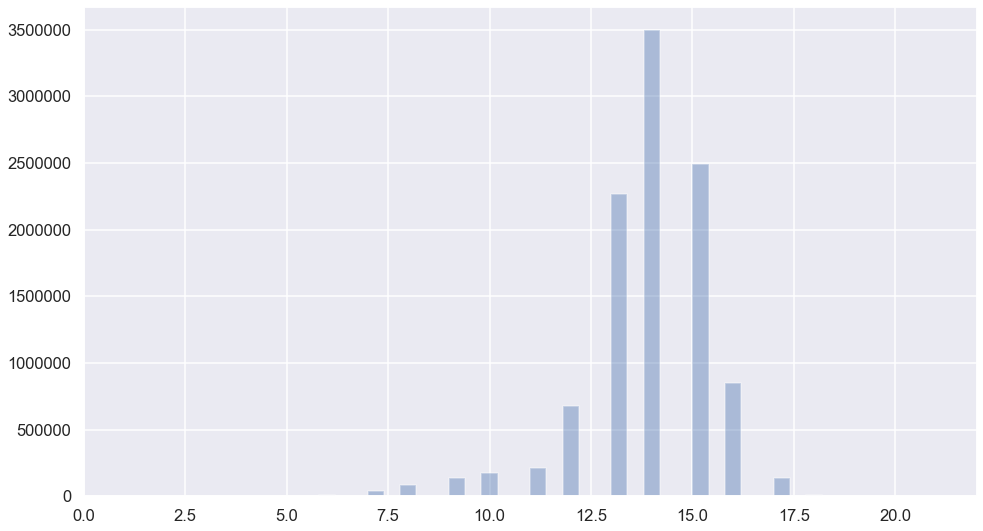

In [819]:
sns.distplot(resampled_traj.loc[(slice(None),'nnb count'),:].to_numpy().flatten(),kde=False)

In [864]:
# throw out any particles that have insufficient nnbs
tmp_idx = (resampled_traj_idx_1_5pct.loc[(slice(None),'nnb count'),'(2,3)'] > 12).droplevel('values')
#tmp = resampled_traj_idx_1_5pct.loc[(slice(None),'exz'),'(2,3)'][(resampled_traj_idx_1_5pct.loc[(slice(None),'nnb count'),'(2,3)'] > 12)]

In [865]:
resampled_traj_idx_1_5pct.loc[(slice(None),'exz'),'(2,3)'].droplevel('values')[tmp_idx]

particle
942      -0.000157
955      -0.001909
963      -0.004271
970      -0.004371
975       0.001085
            ...   
966506   -0.001563
966511    0.003272
966517    0.003026
966525   -0.002695
966614   -0.003312
Name: (2,3), Length: 409312, dtype: float64

/Users/zsolt/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:200: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  line, = ax.plot(a.mean(), 0)
/Users/zsolt/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:352: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)
/Users/zsolt/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:352: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)
/Users/zsolt/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:352: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)
/Users/zsolt/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:352: UserWarning: Attempted to set non-positive bottom ylim on 

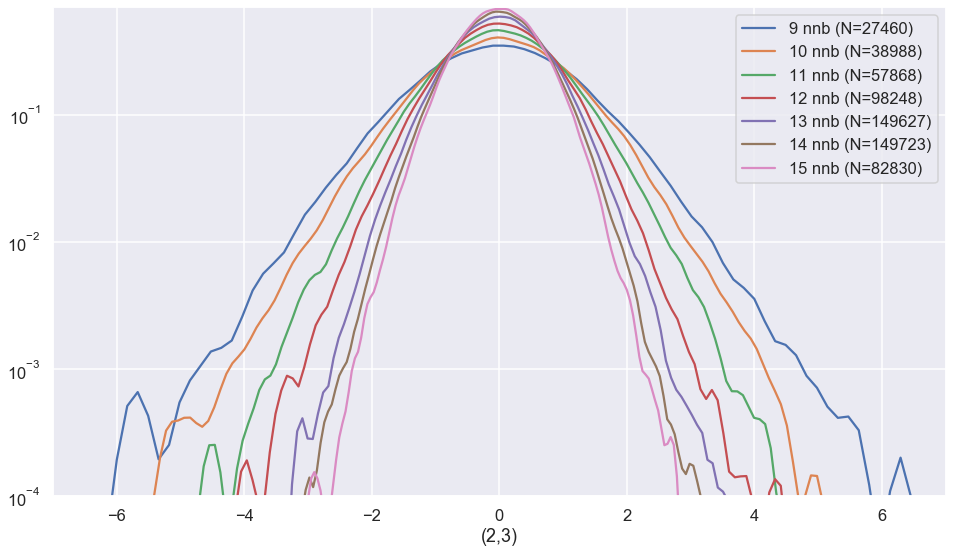

In [1006]:
# plot histogram of low uncertainty and sufficient nnb
f,ax = plt.subplots(figsize=(16,9))
ax.set(yscale='log')

# more than 12 nnb and small locating uncertainty (<1.5% of diameter)
describe_out = {}
for nnb in range(9,16,1):
    #tmp_idx = (resampled_traj.loc[(slice(None),'nnb count'),'(2,3)'] == nnb).droplevel('values')
    tmp_idx = (resampled_traj_idx_1_5pct.loc[(slice(None),'nnb count'),'(2,3)'] == nnb).droplevel('values')
    counts = tmp_idx.value_counts().loc[True]
    sample = 200*resampled_traj_idx_1_5pct.loc[(slice(None),'exz'),'(2,3)'].droplevel('values')[tmp_idx]
    #describe_out['{}'.format(nnb)] = scipy.stats.describe(sample)
    describe_out[nnb] = scipy.stats.describe(sample)
    g = sns.distplot(sample, hist=False, label='{} nnb (N={})'.format(nnb,counts))
    g.set(ylim=(10**(-4),0.7))
    g.set(xlim=(-7,7))
stats_df = pd.DataFrame(describe_out,index=['counts','(min, max)', 'mean', 'variance', 'skewness', 'excess kurtosis']).transpose().rename_axis('nnb')
#how about just move than 12 nnb regardless of locating uncertainty? 


#deleting particles to have low uncertainty but not taking into account loss of nnb is totally wrong 
#sns.distplot(200*resampled_traj_idx_1_5pct.loc[(slice(None),'exz'),'(2,3)'].droplevel('values'))

# compare with gaussian
#xx = np.arange(-6,6,0.05)
#yy = norm.pdf(xx,0,1.15)
#plt.plot(xx,yy,'r')

In [1005]:
(resampled_traj.loc[(slice(None),'nnb count'),'(2,3)'] == nnb).droplevel('values')

particle
0         False
1         False
2         False
3         False
4         False
          ...  
966612     True
966613     True
966614     True
966617    False
966620    False
Name: (2,3), Length: 963752, dtype: bool

In [908]:
tmp_idx = (resampled_traj_idx_1_5pct.loc[(slice(None),'nnb count'),'(2,3)'] == 12).droplevel('values')
tmp_idx.value_counts().loc[True]/1000

98.248

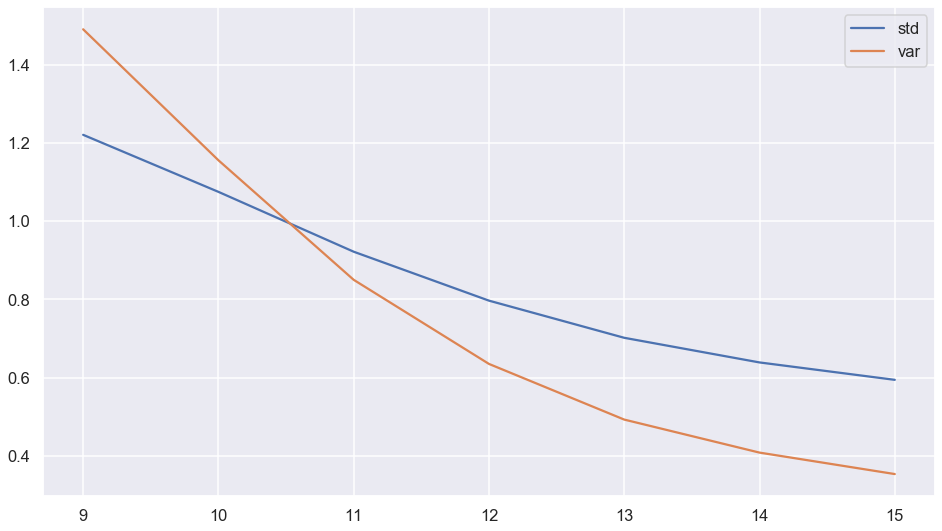

In [990]:
g = sns.lineplot(data = stats_df['variance'].astype('float32').map(np.sqrt), label = 'std')
g = sns.lineplot(data = stats_df['variance'].astype('float32'), label = 'var')

In [995]:
0.6*np.sqrt(15)

2.32379000772445

### compare distributions 

In [13]:

tmp_resampled = resampled_traj.xs('exz',level='values')['(1,2)']
tmp_strain = sedStrain_traj_dt1.xs('exz',level='values')['(0,1)']

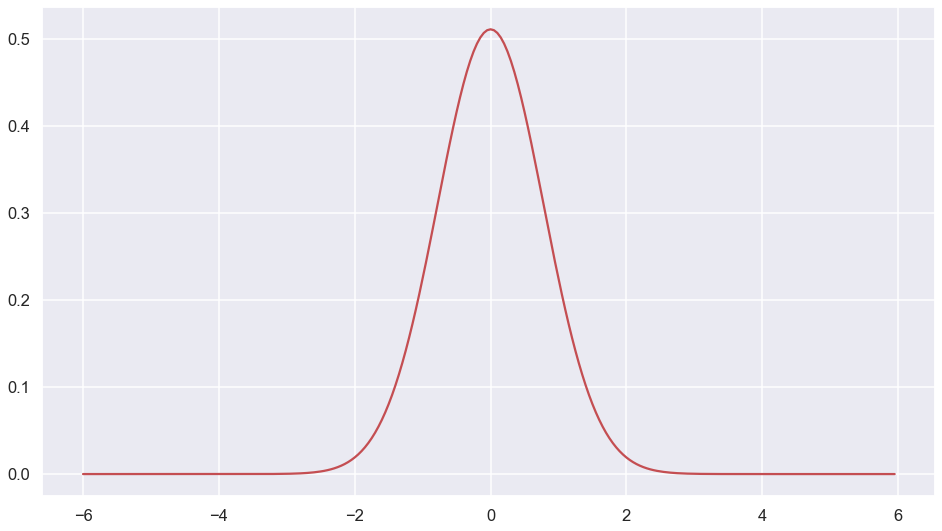

In [70]:
# gaussian model
from scipy.stats import norm
xx = np.arange(-6,6,0.05)
yy = norm.pdf(xx,0,0.78)
plt.plot(xx,yy,'r')

In [52]:
figPath = '/Users/zsolt/Colloid/Figures_Schematics/data_plots'

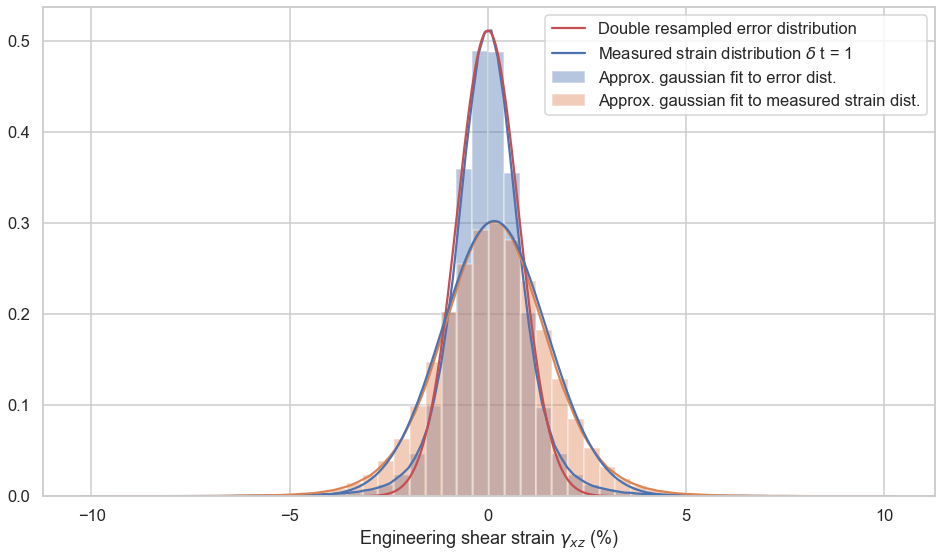

In [17]:
clip = 10/200
sns.set(rc={'figure.figsize':(16,9)})
sns.set_context("talk")
with sns.axes_style('whitegrid'):
    #g = sns.distplot(200*tmp[(tmp < clip) & (tmp > -1*clip)], label = 'Sampled error distribution')
    g = sns.distplot(200*tmp_resampled[(tmp_resampled < clip) & (tmp_resampled > -1*clip)], label = 'Double resampled error distribution')
    g = sns.distplot(200*tmp_strain[(tmp_strain < clip) & (tmp_strain > -1*clip)], label = 'Measured strain distribution $\delta$t = 1')
    g.set_xlabel('Engineering shear strain $\gamma_{xz}$ (%)')
    
    # approx gaussian to error distribution, mu = 0, sigma = 0.78
    xx = np.arange(-6,6,0.05)
    yy = norm.pdf(xx,0,0.78)
    g.plot(xx,yy,'r')
    
    # approx gaussian to measured strain distribution, mu = 0.16, sigma = 1.32
    yy = norm.pdf(xx,0.16,1.32)
    g.plot(xx,yy,'b')
    
    # approx gaussian to ``deconvolved'' strain distribution. 
    # mean and variance are substracted: mu = 0.16 - 0, sigma = sqrt(1.32**2 - 0.78**2)
    #yy = norm.pdf(xx,0.16,1.065)
    #g.plot(xx,yy,'p')
    
    g.legend([ 
              'Double resampled error distribution',
              'Measured strain distribution $\delta$ t = 1', 
              'Approx. gaussian fit to error dist.', 
              'Approx. gaussian fit to measured strain dist.'
              #'Approx. strain distribution deconvolved'
    ])
    #g.figure.savefig(figPath + '/strainDistribution_errorResampling_refConfig_t{:02}.pdf'.format(1),transparent=True, dpi=300)

## Deconvolution

Steps and options:
- get kernel density estimate of both error and measured strain distributions
- apply fourier inversion formula to obtain deconvolved strain distribution using noise model:
  - error distribution: $f_{error}(X)$
  - measured strain distribtion $f_{\epsilon)(X)$
  - true distribution $g_\epsilon (X)$
  - $ f_\epsilon = f_{error} * g_\epsilon$
  - $ g_\epsilon = \mathcal{F}^{-1}\{\frac{\mathcal{F}(f_\epsilon)}{\mathcal{F}(f_{error})}\}$
- Also check the importance of heteroskedasticty of the locating error by sampling configurations with uniform locating errors. 
- Finally measure the spatial correlation of the noise field. 

/Users/zsolt/.conda/envs/TractionRheoscopy/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

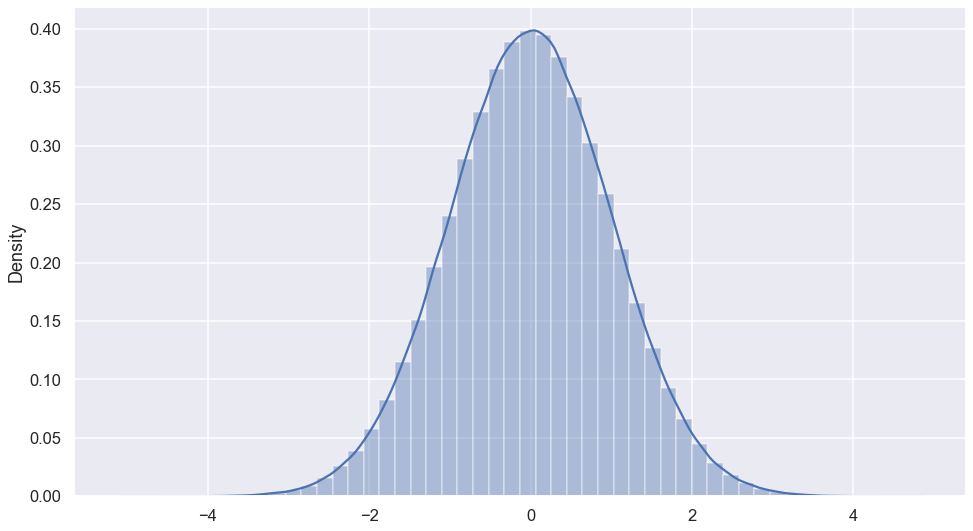

In [101]:
# get a kernel density plot from a distribution
# lets sample a gaussian
mu1, mu2 = (0, 10)
sigma1, sigma2 = (1,0.8)
g = np.random.normal(mu1,sigma1,1000000)
sns.distplot(g,kde=True)

<AxesSubplot:>

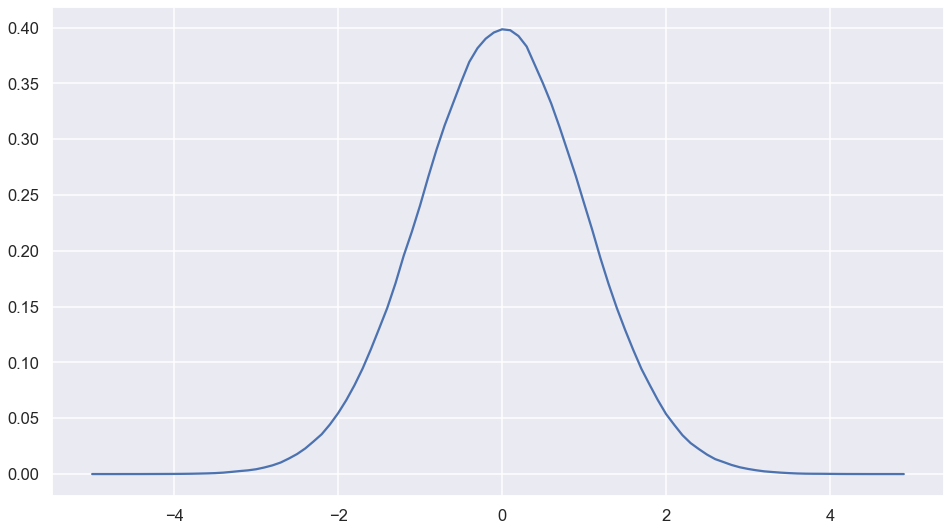

In [123]:
# compute the kde 
from scipy.stats import gaussian_kde
kde = gaussian_kde(g)
val = kde(np.arange(-5, 5, 0.1))
sns.lineplot(x = np.arange(-5,5,0.1), y = val)

In [135]:
# can you fft the kde and get the desired result?
from scipy.fft import fft, ifft
from scipy.fftpack import fftshift, fftfreq

<AxesSubplot:>

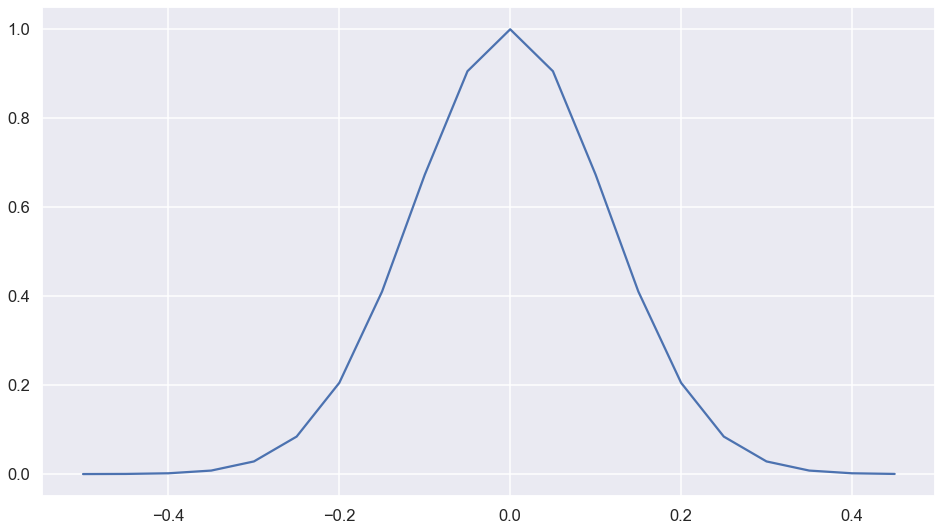

In [229]:
# Plot the power spectrum taking into account the various intricacies of DFT and FFT
# See: https://warwick.ac.uk/fac/sci/mathsys/courses/msc/ma934/resources/notes8.pdf
delta = 0.2
N=10
t = np.arange(-N,N,delta)
val = kde(t)
valHat = fft(val)
center = int(t.shape[-1]/2)
f_range = int(0.2*center)
sns.lineplot(y = ((delta*(np.abs(fftshift(valHat))))**2)[center - f_range: center + f_range], 
             x = fftshift(fftfreq(t.shape[-1],delta))[center-f_range : center + f_range])

<AxesSubplot:>

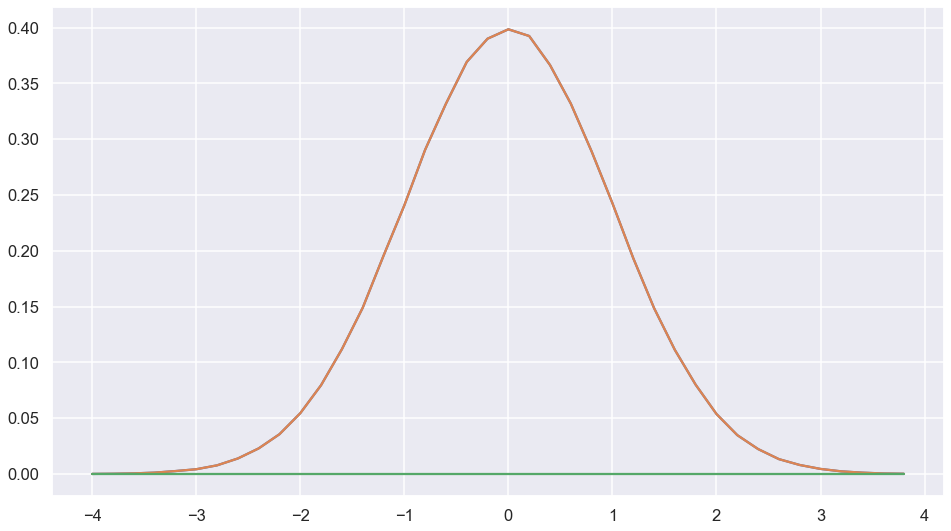

In [231]:
# what about inverse fft? 
val2 = ifft(valHat)
val2
sns.lineplot(y = abs(val2)[center-20: center+20], x=t[center-20:center+20])
sns.lineplot(y=kde(t[center-20: center+20]),x=t[center-20:center+20])
sns.lineplot(y=kde(t[center-20: center+20])-abs(val2)[center-20: center+20], x=t[center-20:center+20])

## Additive noise model 

What I should do know is simulate signal and noise through sampling
-add in noise to the signal 
- separately determine the distrubtion of the signal and noise and convolve the distribtution
- compared noise model with convolved distributions
- determine kernel density for measurement
- apply naive inverse with fft to measurement and compare with true signal

In [23]:
# can you fft the kde and get the desired result?
import numpy as np
import seaborn as sns
import scipy
from matplotlib import pyplot as plt
from scipy.fft import fft, ifft
from scipy.fftpack import fftshift, fftfreq
from scipy import signal
from scipy.stats import gaussian_kde

In [24]:
sns.set(rc={'figure.figsize':(16,9)})
sns.set_context("talk")

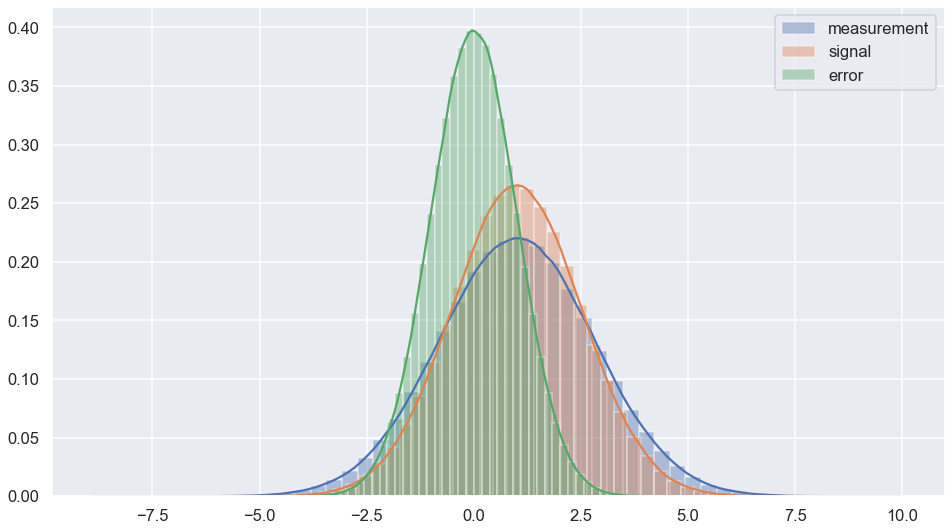

In [484]:
# simulate measurement = signal + error, where both signal and error are sampled from a normal distribution. 
# if this is done correctly, kde(measurement) = kde(signal)*kde(error), where * is convolution. Check this explicitly. 
N = 10**6
mu_signal, mu_error = (1, 0)
sigma_signal, sigma_error = (1.5,1)
signal_sample = np.random.normal(mu_signal,sigma_signal,N)
error_sample = np.random.normal(mu_error, sigma_error,N)
measurement_sample = signal_sample + error_sample
sns.distplot(measurement_sample,label = 'measurement')
sns.distplot(signal_sample,label='signal')
sns.distplot(error_sample,label='error')
plt.legend()

#sns.distplot(g,kde=True)
#signal_sample = np.normal 

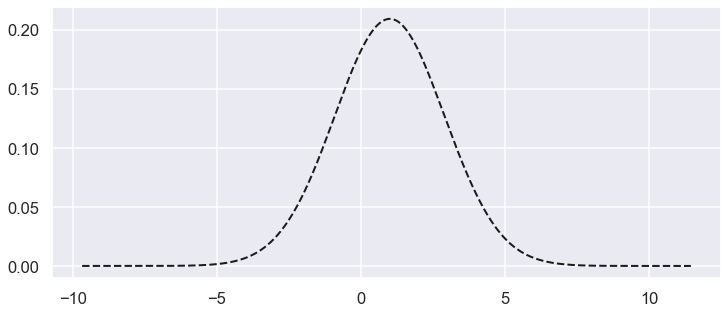

In [121]:
# see what effect bandwidth parameter has
import statsmodels.api as sm
kde = sm.nonparametric.KDEUnivariate(measurement_sample)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
for bandwidth in [10*10**(-6/5)]:
    kde.fit(bw=bandwidth) # Estimate the densities
    ax.plot(kde.support, kde.density, '--', lw=2, color='k', zorder=10,
            label='KDE from samples, bw = {}'.format(round(bandwidth, 2)))

In [575]:
delta = 0.1
t = np.arange(-7,7,delta)


error_kde = gaussian_kde(error_sample)
error_pmf = error_kde(t)

signal_kde = gaussian_kde(signal_sample)
signal_pmf = signal_kde(t)

measurement_kde = gaussian_kde(measurement_sample)
measurement_pmf = measurement_kde(t)

signal_conv = delta*scipy.signal.fftconvolve(signal_pmf,error_pmf,'same')

In [576]:
1.06*np.sqrt(1.5**2 + 1)

1.9109421759959144

In [577]:
#bw = N**(-1/(1+4)) # Scott's rule
# Silverman's rule: ~1.06*sigma*n**(-1/5)
bw = lambda a: a*N**(-1/(1+4)) 

measurement_kdeSmooth = gaussian_kde(measurement_sample,bw_method=bw(2))
measurement_pmfSmooth = measurement_kdeSmooth(t)

error_kdeSmooth = gaussian_kde(error_sample,bw_method=bw(2))
error_pmfSmooth = error_kdeSmooth(t)



# I think the major problem is some noise and I didnt shift and scale the distributions correctly
# I should look into Weiner filter to cut down on noise
# There is a light at the end of the tunnel because if sampling freq is set to one, the recoverd signal looks a lot like the
# convolved signal but with a clear fft shift problem. 
# I also dont understand why the measurement and convolved signals shift closer together depending on the sampling rate?
#deconvolved = np.real(ifft(fft(signal)*np.conj(H)/(H*np.conj(H) + lambd**2)))

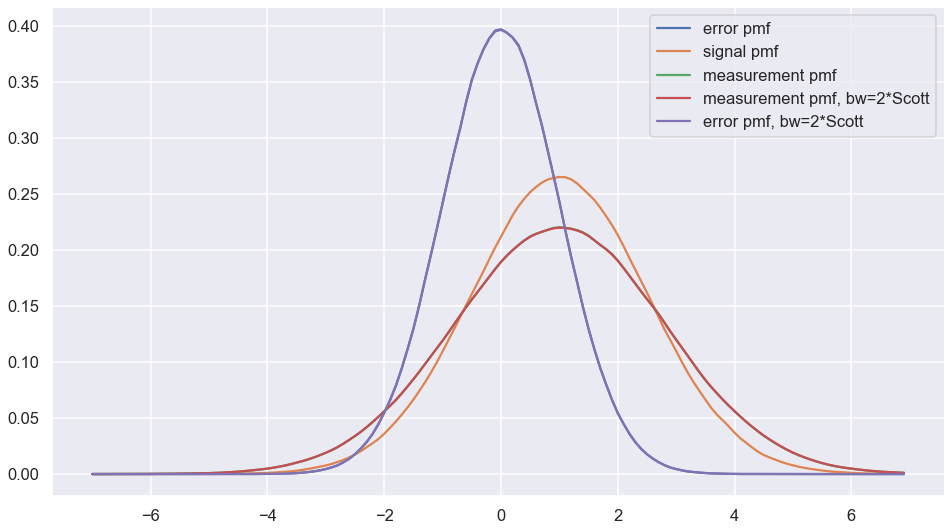

In [578]:
# check the kde
sns.lineplot(y=error_pmf, x=t,label='error pmf')
sns.lineplot(y=signal_pmf, x=t, label = 'signal pmf')
sns.lineplot(y=measurement_pmf, x=t, label = 'measurement pmf')
sns.lineplot(y=measurement_pmfSmooth, x=t, label = 'measurement pmf, bw=2*Scott')
sns.lineplot(y=error_pmfSmooth, x=t, label = 'error pmf, bw=2*Scott')
plt.legend()

In [581]:
# Weiner deconvolution 
#signal_decon = np.real(ifft(fft(measurement_pmf)*np.conj(error_pmf)/(fft(error_pmf)*np.conj(fft(error_pmf)) + 100)))
h = fft(error_pmfSmooth)*np.conj(fft(error_pmfSmooth))
d = 100
snr = d*np.real((np.conj(fft(measurement_pmfSmooth))*fft(measurement_pmfSmooth))/(np.conj(fft(error_pmfSmooth))*fft(error_pmfSmooth)))
signal_decon = ifft(fft(measurement_pmfSmooth)/fft(error_pmfSmooth)*1/(1 + 1/(h*snr)))/delta

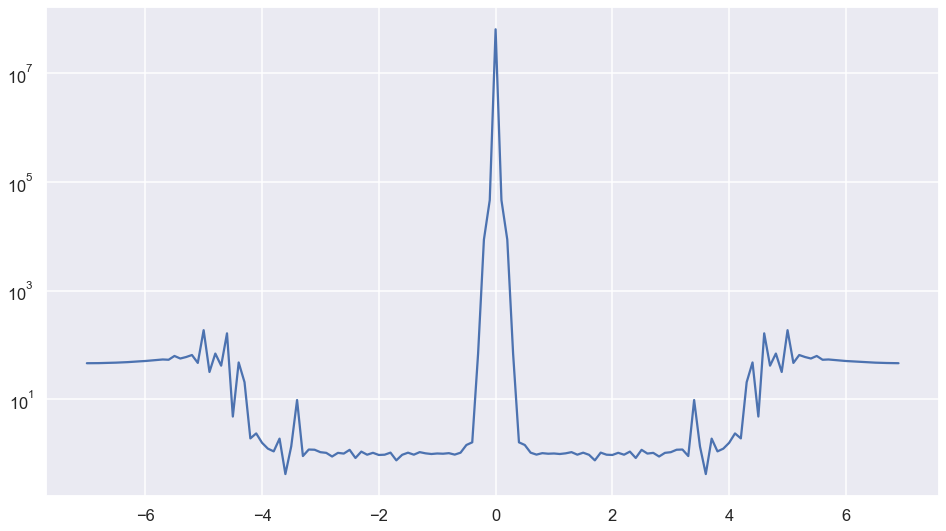

In [579]:
# didnt realy work as well as the above.
# Update, this is just wrong. You have to use the ratio of psd even according to wikipedia although the notation is misleading. 
#snr = 10*np.real(fft(measurement_pmfSmooth)/fft(error_pmfSmooth))
# snr should really be the ratio of powerspectral densities of ideal gaussian and gaussian inferred through kde? After reading wikipedia

# let try estimating the snr to be ratio of psd of ideal guassian and gaussian inferred through kde

import scipy.stats

N_ideal=10**5
mu_ideal = 0
sigma_ideal = 2

# generate an ideal gausian pmf
idealSignal = scipy.stats.norm(loc=mu_ideal,scale=sigma_ideal)
idealSignal_pmf = idealSignal.pdf(t)

# sample from that distribution the same number of times as you sampled the error
idealSampled = np.random.normal(mu_ideal, sigma_ideal, N_ideal)
#ideal_kdeSmooth = gaussian_kde(idealSampled,bw_method=bw(2))
ideal_kdeSmooth = gaussian_kde(idealSampled)
ideal_pmfSmooth = ideal_kdeSmooth(t)

samplingError = ideal_pmfSmooth - idealSignal_pmf

#sns.lineplot(x=t, y=samplingError)

snrSamplingNoise = np.abs((np.conj(fft(ideal_pmfSmooth))*fft(ideal_pmfSmooth))/(np.conj(fft(samplingError))*fft(samplingError)))

f,ax = plt.subplots(figsize=(16,9))
ax.set(yscale='log')
sns.lineplot(y=snrSamplingNoise, x=fftshift(t))

#measuredSignal = np.random.normal(mu_signal,sigma_signal,N)
# fft and take ratio

In [582]:
###### signal_decon = ifft(fft(measurement_pmfSmooth)/fft(error_pmfSmooth)*1/(1 + 1/(h*snr)))/delta
signal_decon = ifft(fft(measurement_pmfSmooth)/fft(error_pmfSmooth)*1/(1 + 1/(h*snrSamplingNoise)))/delta
#signal_deconNaive = ifft(fft(measurement_pmfSmooth)/fft(error_pmfSmooth))/delta

# this thing is even more shit
#signal_decon2, remainder = scipy.signal.deconvolve(measurement_pmf,error_pmf+0.00001)

In [510]:
#sns.lineplot(y=h*snrSamplingNoise,x=fftshift(t))

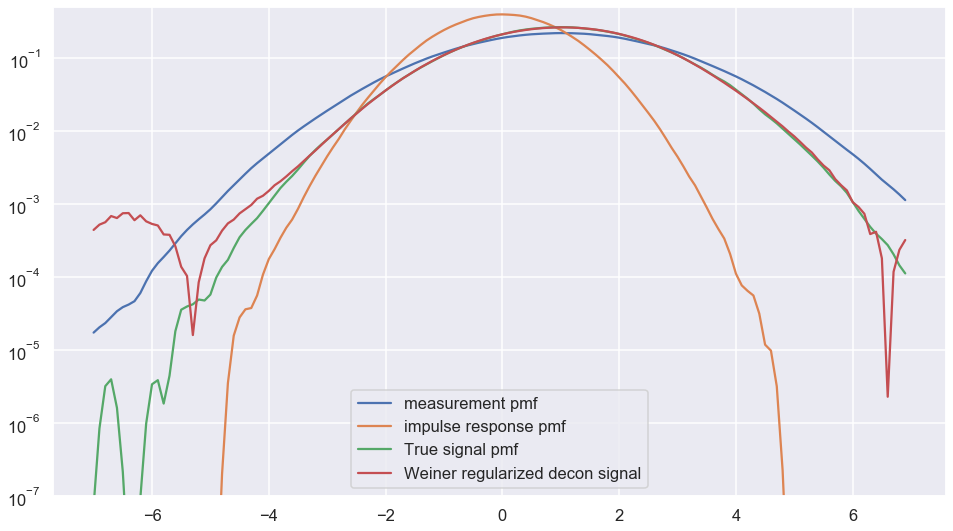

In [586]:
f,ax = plt.subplots(figsize=(16,9))
ax.set(yscale='log')
g = sns.lineplot(y=measurement_pmfSmooth,x=t,label='measurement pmf')
sns.lineplot(y=error_pmfSmooth,x=t,label='impulse response pmf')
sns.lineplot(y=signal_pmf,x=t,label='True signal pmf')
sns.lineplot(y=np.abs(signal_decon),x=fftshift(t),label='Weiner regularized decon signal')
g.set(ylim=(10**(-7),0.5))
#sns.lineplot(y=np.abs(signal_deconNaive),x=fftshift(t),label='Naive inverse decon ')
#sns.lineplot(y=signal_conv,x=t,label='convolved signal*error ~ measurement')
#sns.lineplot(y=signal_decon2,x=t,label='scipy signal deconvolve')
plt.legend()

In [587]:
g.figure.savefig(figPath + '/gaussianDecon_testCase_logPlot.pdf', dpi=300)

## Deconvolve a single strain masurement

In [519]:
figPath = '/Users/zsolt/Colloid/DATA/tfrGel10212018x/tfrGel10212018A_shearRun10292018f/plots/uncertaintyAnalysis_errorChainMonteCarlo'

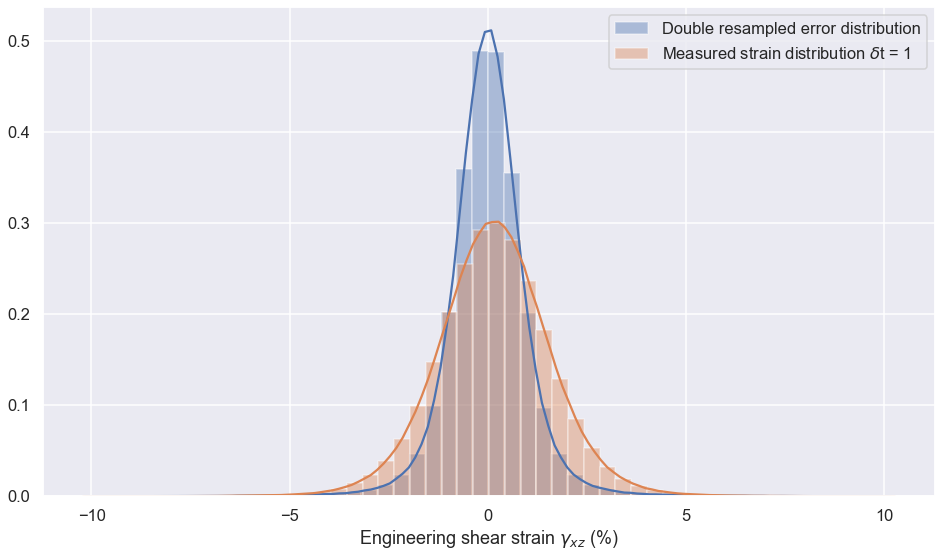

In [588]:
clip = 10/200
g = sns.distplot(200*tmp_resampled[(tmp_resampled < clip) & (tmp_resampled > -1*clip)], label = 'Double resampled error distribution')
g = sns.distplot(200*tmp_strain[(tmp_strain < clip) & (tmp_strain > -1*clip)], label = 'Measured strain distribution $\delta$t = 1')
g.set_xlabel('Engineering shear strain $\gamma_{xz}$ (%)')
plt.legend()

In [521]:
g.figure.savefig(figPath + '/strainDistribution_w_kde.pdf', dpi=300)

In [590]:
# form pmf for measurement, impulse response, and sampling error
impulse_hist = 200*tmp_resampled[(tmp_resampled < clip) & (tmp_resampled > -1*clip)]
measurement_hist = 200*tmp_strain[(tmp_strain < clip) & (tmp_strain > -1*clip)]

# set the range and sampling interval
delta = 0.1
t = np.arange(-10,10,delta)

# generate the probability mass functions 
impulse_kde = gaussian_kde(impulse_hist)
impulse_pmf = impulse_kde(t)

measurement_kde = gaussian_kde(measurement_hist)
measurement_pmf = measurement_kde(t)

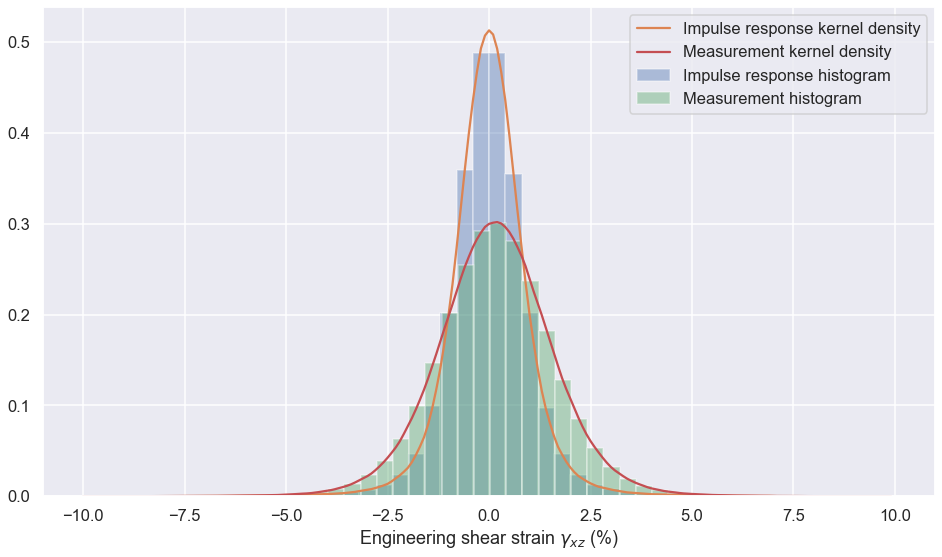

In [592]:
# visualize kde over histogram
g = sns.distplot(impulse_hist, kde=False, norm_hist = True, label='Impulse response histogram')
sns.lineplot(y=impulse_pmf, x= t, label = "Impulse response kernel density")
sns.distplot(measurement_hist, kde=False, norm_hist = True, label='Measurement histogram')
sns.lineplot(y=measurement_pmf, x= t, label = "Measurement kernel density")
g.set_xlabel('Engineering shear strain $\gamma_{xz}$ (%)')
plt.legend()

In [593]:
g.figure.savefig(figPath + '/strainDistribution_w_kde.pdf', dpi=300)

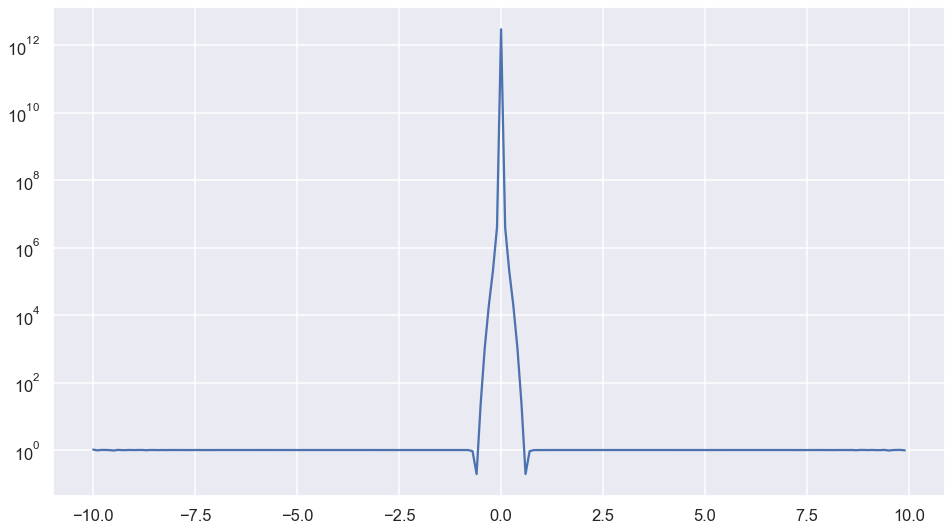

In [528]:
# simulate the error and check SNR as a function of frequency

N_ideal=len(impulse_hist)
mu_ideal = 0
sigma_ideal = 2

# generate an ideal gausian pmf
idealSignal = scipy.stats.norm(loc=mu_ideal,scale=sigma_ideal)
idealSignal_pmf = idealSignal.pdf(t)

# sample from that distribution the same number of times as you sampled the error
idealSampled = np.random.normal(mu_ideal, sigma_ideal, N_ideal)
#ideal_kdeSmooth = gaussian_kde(idealSampled,bw_method=bw(2))
ideal_kdeSmooth = gaussian_kde(idealSampled)
ideal_pmfSmooth = ideal_kdeSmooth(t)

samplingError = ideal_pmfSmooth - idealSignal_pmf

#sns.lineplot(x=t, y=samplingError)

snrSamplingNoise = np.real((np.conj(fft(ideal_pmfSmooth))*fft(ideal_pmfSmooth))/(np.conj(fft(samplingError))*fft(samplingError)))

f,ax = plt.subplots(figsize=(16,9))
ax.set(yscale='log')
sns.lineplot(y=snrSamplingNoise, x=fftshift(t))

In [529]:
h = fft(impulse_pmf)*np.conj(fft(impulse_pmf))
#d = 100
#snr = d*np.real((np.conj(fft(measurement_pmfSmooth))*fft(measurement_pmfSmooth))/(np.conj(fft(error_pmfSmooth))*fft(error_pmfSmooth)))
signal_decon = ifft(fft(measurement_pmf)/fft(impulse_pmf)*1/(1 + 1/(h*snrSamplingNoise)))/delta

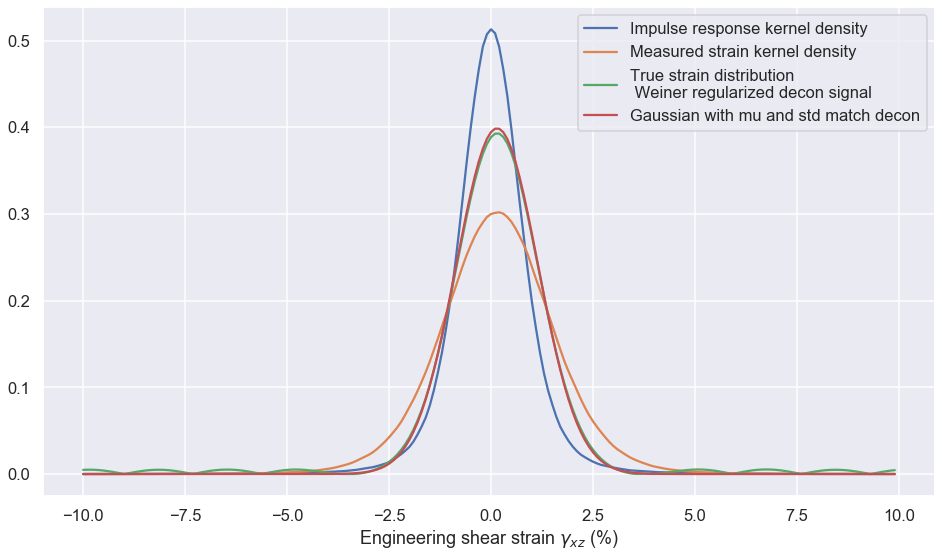

In [530]:
f,ax = plt.subplots(figsize=(16,9))
#ax.set(yscale='log')
#g = sns.distplot(impulse_hist, kde=False, norm_hist = True, label='`Impulse`: Strain from particle locating \n uncertainties')
g = sns.lineplot(y=impulse_pmf, x= t, label = "Impulse response kernel density")
#sns.distplot(measurement_hist, kde=False, norm_hist = True, label='Measured strain histogram')
sns.lineplot(y=measurement_pmf, x= t, label = "Measured strain kernel density")
sns.lineplot(y=np.abs(signal_decon),x=fftshift(t),label='True strain distribution \n Weiner regularized decon signal')
sns.lineplot(y=scipy.stats.norm(loc=0.149,scale=1).pdf(t), x=t,label='Gaussian with mu and std match decon')
g.set_xlabel('Engineering shear strain $\gamma_{xz}$ (%)')

plt.legend()

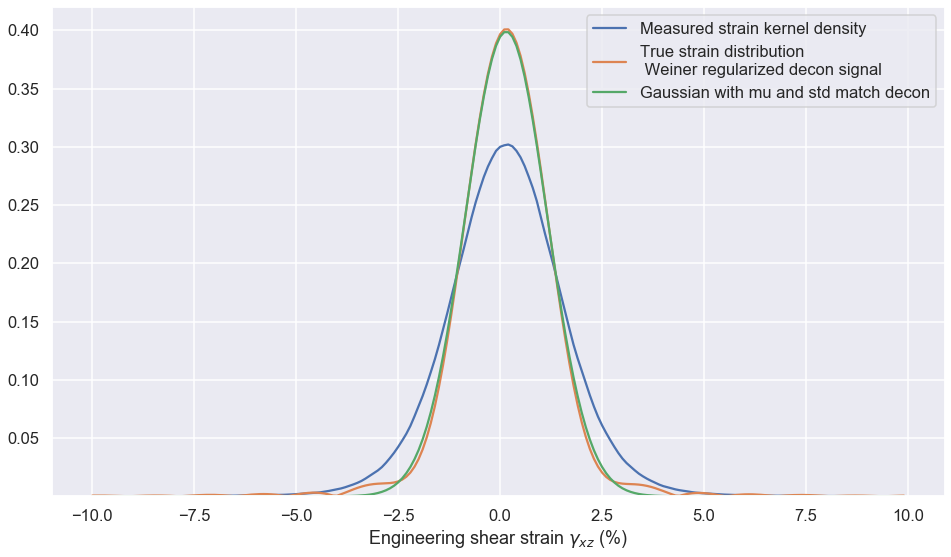

In [568]:
f,ax = plt.subplots(figsize=(16,9))
#ax.set(yscale='log')
#g = sns.distplot(impulse_hist, kde=False, norm_hist = True, label='`Impulse`: Strain from particle locating \n uncertainties')
#g = sns.lineplot(y=impulse_pmf, x= t, label = "Impulse response kernel density")
#sns.distplot(measurement_hist, kde=False, norm_hist = True, label='Measured strain histogram')
g=sns.lineplot(y=measurement_pmf, x= t, label = "Measured strain kernel density")
sns.lineplot(y=np.abs(signal_decon),x=fftshift(t),label='True strain distribution \n Weiner regularized decon signal')
sns.lineplot(y=scipy.stats.norm(loc=0.149,scale=1).pdf(t), x=t,label='Gaussian with mu and std match decon')

g.set_xlabel('Engineering shear strain $\gamma_{xz}$ (%)')
g.set(ylim=(10**(-5),0.42))
plt.legend()

In [558]:
g.figure.savefig(figPath + '/weinerDecon_strain_logPlot.pdf', dpi=300)

In [548]:
mu, sigma, skew = [describe_pmf(np.abs(signal_decon),fftshift(t)).get(key) for key in ['mean','standard deviation','skew']] 

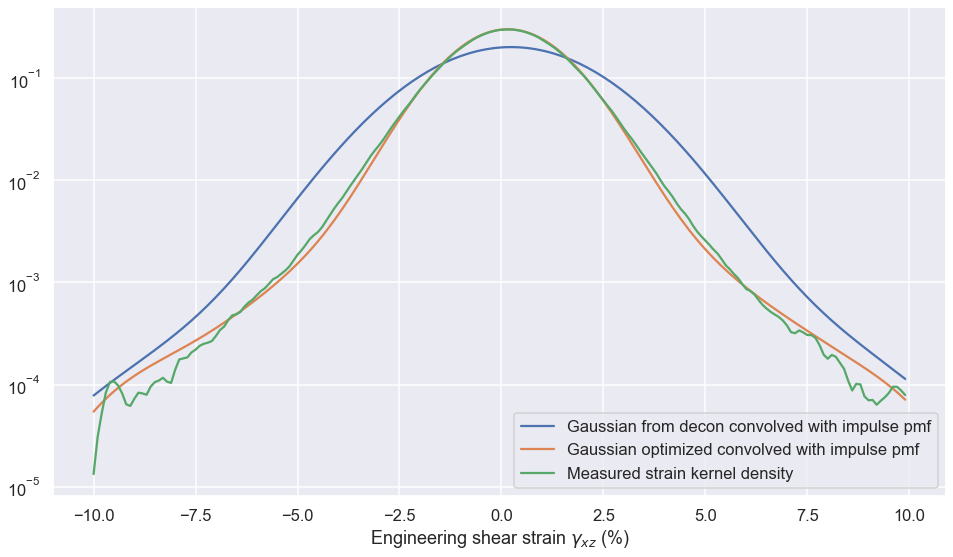

In [594]:
#gaussian_optimized = scipy.stats.skewnorm(a=skew,loc=0.4*mu,scale=0.88*sigma).pdf(t)
gaussian_optimized = scipy.stats.skewnorm(a=skew,loc=0.4*mu,scale=1).pdf(t)
gaussian_decon = scipy.stats.skewnorm(a=skew,loc=mu,scale=sigma).pdf(t)
signal_convDecon = delta*scipy.signal.fftconvolve(gaussian_decon,impulse_pmf,'same')
signal_convOptimized = delta*scipy.signal.fftconvolve(gaussian_optimized,impulse_pmf,'same')
f,ax = plt.subplots(figsize=(16,9))
ax.set(yscale='log')
g = sns.lineplot(y=signal_convDecon, x= t,label='Gaussian from decon convolved with impulse pmf')
sns.lineplot(y=signal_convOptimized, x= t,label='Gaussian optimized convolved with impulse pmf')
sns.lineplot(y=measurement_pmf, x= t, label = "Measured strain kernel density")
g.set_xlabel('Engineering shear strain $\gamma_{xz}$ (%)')

plt.legend()

In [595]:
g.figure.savefig(figPath + '/impulseKDE_conv_gaussian_log.pdf', dpi=300)

In [ ]:
# compute descriptive statistics from probability mass functions

# mean: sum(d(strain_i)*p_i) where the sum runs over the bins and d is sampling constant. 
# std: 

In [88]:
def mean_pmf(p,t):
    """
    p is a list of probability values sampled at regular intervals
    t is a list of bin locations
    return the average value
    """
    d = t[1] - t[0]
    return sum(d*p*t)

def std_pmf(p,t):
    """
    p is a list of probility values sampled at regular intervals
    t is a list of bin locations 
    returns the standard deviation. 
    """
    mean = mean_pmf(p,t)
    d = t[1] - t[0]
    return np.sqrt(sum(d*p*(t - mean)**2))

def skew_pmf(p,t):
    d = t[1] - t[0]
    mu = mean_pmf(p,t)
    sigma = std_pmf(p,t)
    return sum(d*p*((t-mu)/(sigma)**3))

def kurtosis_pmf(p,t,excess=False):
    d = t[1] - t[0]
    mu = mean_pmf(p,t)
    sigma = std_pmf(p,t)
    kurtosis = sum(d*p*((t-mu)/(sigma))**4)
    if excess == False: return kurtosis
    elif excess == True: return kurtosis - 3 
    else: raise(KeyError)

def checkNorm(p,t):
    """
    check that p is normalized to 1
    """
    d = t[1]-t[0]
    total = sum(d*p)
    return total

def describe_pmf(p,t):
    return {'norm': checkNorm(p,t), 
            'mean': mean_pmf(p,t), 
            'standard deviation': std_pmf(p,t),
            'skew': skew_pmf(p,t), 
            'kurtosis':kurtosis_pmf(p,t)}

NameError: name 'N' is not defined

/Users/zsolt/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:200: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  line, = ax.plot(a.mean(), 0)


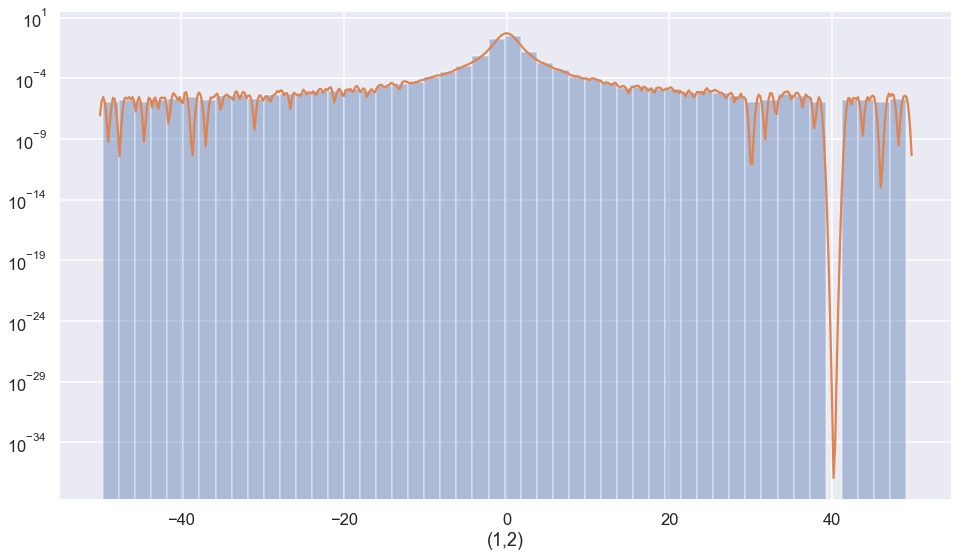

In [241]:
# more optimal bandwidth selection for error distribution
clip = 50/200
impulse_hist_tmp = 200*tmp_resampled[(tmp_resampled < clip) & (tmp_resampled > -1*clip)]
N = len(impulse_hist_tmp)
t_extended = np.arange(-50,50,0.2)
bw = lambda a: a*N**(-1/(1+4)) 
impulse_kde_tmp = gaussian_kde(impulse_hist_tmp,bw_method=bw(2))
#ideal_kdeSmooth = gaussian_kde(idealSampled)
#ideal_pmfSmooth = ideal_kdeSmooth(t)
f,ax = plt.subplots(figsize=(16,9))
ax.set(yscale='log')
sns.distplot(impulse_hist_tmp, norm_hist=True, kde=False)
sns.lineplot(y=impulse_kde_tmp.pdf(t_extended), x = t_extended)

In [213]:
# perhaps I would increase snr by including more resamples
resampled_traj.xs('exz',level='values')
resampled_Strain_3times = np.concatenate([resampled_traj.xs('exz',level='values')['({},{})'.format()].to_numpy(),
                                    resampled_traj.xs('exz',level='values')['(2,3)'].to_numpy(),
                                    resampled_traj.xs('exz',level='values')['(3,4)'].to_numpy()])

In [232]:
resampled_Strain = np.concatenate([resampled_traj.xs('exz',level='values')['({},{})'.format(x,x+1)].to_numpy() for x in range(1,11)])

In [526]:
t = np.arange(-10,10,delta)

/Users/zsolt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/zsolt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/zsolt/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:200: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  line, = ax.plot(a.mean(), 0)


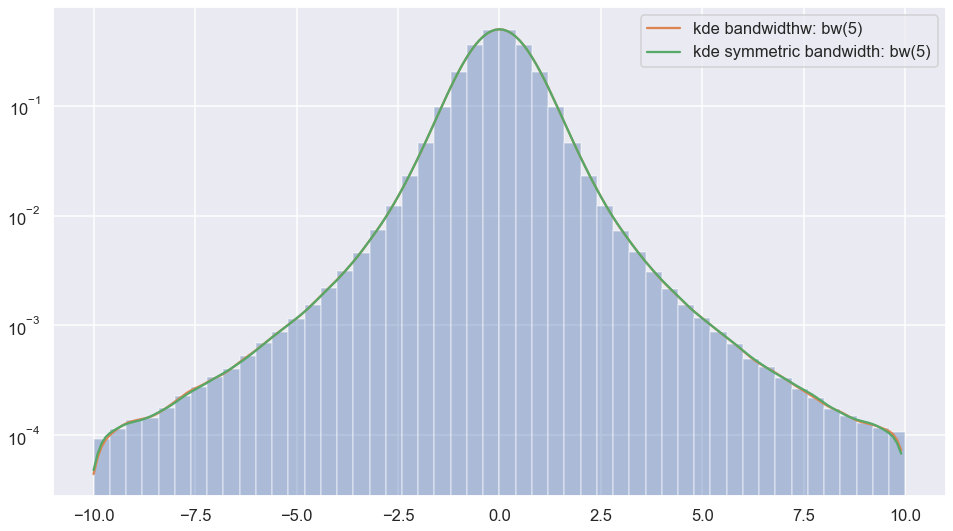

In [559]:
clip = 10/200
delta = 0.1
impulse_hist_tmp = 200*resampled_Strain[(resampled_Strain < clip) & (resampled_Strain > -1*clip)]
# perhaps we can fold the distribution since we know it has to be symmetric. 
impulse_hist_symmetricFold = np.concatenate([np.abs(impulse_hist_tmp),-1*np.abs(impulse_hist_tmp)])
N = len(impulse_hist_tmp)
t = np.arange(-10,10,delta)
bw = lambda a: a*N**(-1/(1+4)) 
a = 5
impulse_kde_tmp = gaussian_kde(impulse_hist_tmp,bw_method=bw(a))
impulse_kde_sym = gaussian_kde(impulse_hist_symmetricFold,bw_method=bw(a))
#ideal_kdeSmooth = gaussian_kde(idealSampled)
#ideal_pmfSmooth = ideal_kdeSmooth(t)
f,ax = plt.subplots(figsize=(16,9))
ax.set(yscale='log')
g = sns.distplot(impulse_hist_tmp, norm_hist=True, kde=False)
sns.lineplot(y=impulse_kde_tmp.pdf(t_extended), x = t_extended,label='kde bandwidthw: bw({})'.format(a))
sns.lineplot(y=impulse_kde_sym.pdf(t_extended), x = t_extended, label = 'kde symmetric bandwidth: bw({})'.format(a))
g.legend()

In [560]:
g.figure.savefig(figPath + '/impulseResponse_10Samples_kdeClipped.pdf', dpi=300)

In [304]:
# using this impulse response, without changing SNR run Weiner deconvolution
# zero pad out to strain of 100, symmetrically
impulse_kde_pdf = impulse_kde_sym.pdf(t)
# perhaps subtract the tail probabilities of 10e-6 from the pmf, although maybe thats not necessary. 
# run weiner deconvolution

In [263]:
#len(impulse_kde_pdf)
#len(np.arange(-100,100,0.2))
impulse_kde_padded = np.pad(impulse_kde_pdf, int((1000-500)/2))
t_padded = np.arange(-100,100,0.1)

In [599]:
# estimate sample noise from sampling of impulse response
impulse_sample_hist = resampled_traj.xs('exz',level='values')['(2,3)']
clip = 10/200
impulse_sample_hist = 200*impulse_sample_hist[(impulse_sample_hist < clip) & (impulse_sample_hist > -1*clip)]

impulse_kde_sampling_kde = gaussian_kde(impulse_sample_hist)
impulse_kde_sampling_pmf = impulse_kde_sampling_kde.pdf(t)

impulse_kde_sym_pmf = impulse_kde_sym.pdf(t)

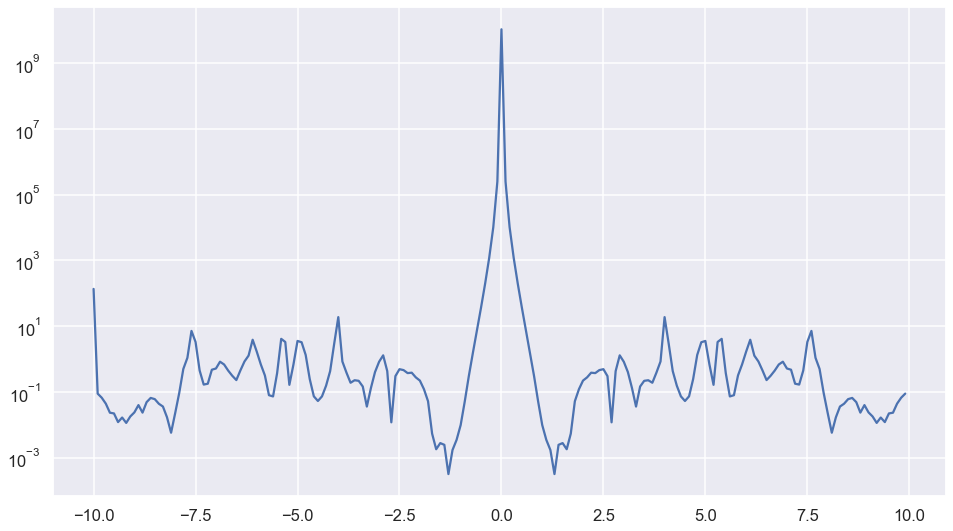

In [600]:
samplingError = (impulse_kde_sym_pmf - impulse_kde_sampling_pmf)
#snrSamplingNoise = np.abs((np.conj(fft(impulse_kde_sampling_pmf))*fft(impulse_kde_sampling_pmf))/(np.conj(fft(samplingError))*fft(samplingError)))
snrSamplingNoise = np.abs((np.conj(fft(measurement_padded_pmf))*fft(measurement_padded_pmf))/(np.conj(fft(samplingError))*fft(samplingError)))

f,ax = plt.subplots(figsize=(16,9))
ax.set(yscale='log')
sns.lineplot(y=snrSamplingNoise, x=fftshift(t))

In [563]:
g.figure.savefig(figPath + '/snr_impulseSampleNoise_measurementSignal.pdf', dpi=300)

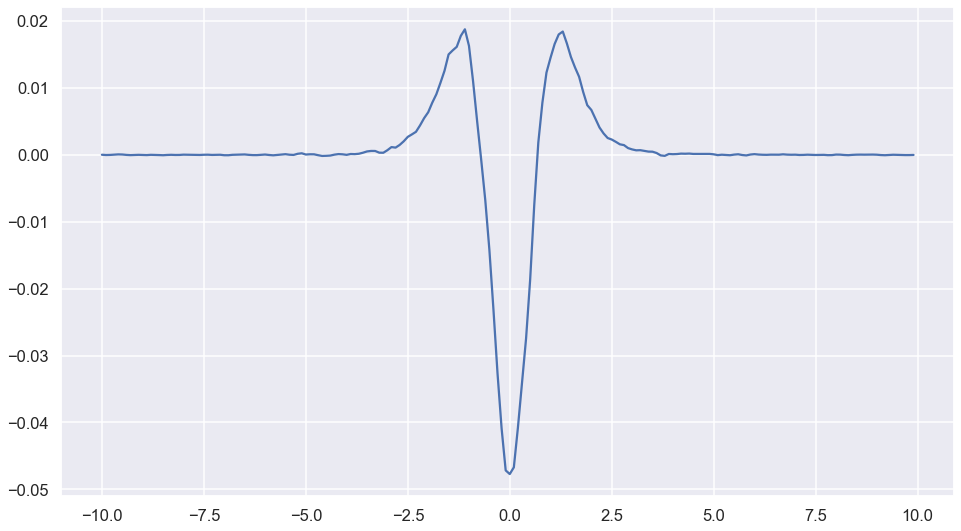

In [408]:
sns.lineplot(x=t, y= samplingError)

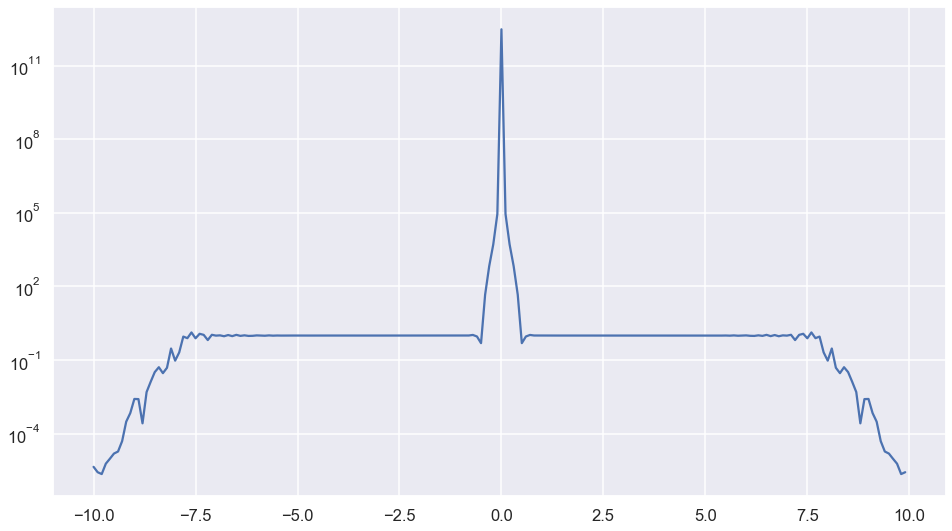

In [319]:
# estimate sampling noise
# simulate the error and check SNR as a function of frequency

#N_ideal=len(impulse_hist)
N_ideal = 10**5
mu_ideal = 0
sigma_ideal = 2
t_sampling = np.arange(-100,100,0.1)

# generate an ideal gausian pmf
idealSignal = scipy.stats.norm(loc=mu_ideal,scale=sigma_ideal)
idealSignal_pmf = idealSignal.pdf(t)

# sample from that distribution the same number of times as you sampled the error
idealSampled = np.random.normal(mu_ideal, sigma_ideal, N_ideal)
#ideal_kdeSmooth = gaussian_kde(idealSampled,bw_method=bw(2))
ideal_kdeSmooth = gaussian_kde(idealSampled)
ideal_pmfSmooth = ideal_kdeSmooth(t)

samplingError = ideal_pmfSmooth - idealSignal_pmf

#sns.lineplot(x=t, y=samplingError)

snrSamplingNoise = np.abs((np.conj(fft(ideal_pmfSmooth))*fft(ideal_pmfSmooth))/(np.conj(fft(samplingError))*fft(samplingError)))

f,ax = plt.subplots(figsize=(16,9))
ax.set(yscale='log')
sns.lineplot(y=snrSamplingNoise, x=fftshift(t))

In [601]:
bw = lambda a: a*N**(-1/(1+4)) 
a = 5

impulse_kde_sym = gaussian_kde(impulse_hist_symmetricFold,bw_method=bw(a))
impulse_kde_pdf = impulse_kde_sym.pdf(t)
h = fft(impulse_kde_sym_pmf)*np.conj(fft(impulse_kde_sym_pmf))
measurement_padded_pmf = measurement_kde.pdf(t)

In [602]:
#d = 100
#snr = d*np.real((np.conj(fft(measurement_pmfSmooth))*fft(measurement_pmfSmooth))/(np.conj(fft(error_pmfSmooth))*fft(error_pmfSmooth)))
signal_decon = ifft(fft(measurement_padded_pmf)/fft(impulse_kde_sym_pmf)*1/(1 + 1/(h*snrSamplingNoise)))/0.1

{'norm': 1.0144909791129932,
 'mean': 0.14797743698174964,
 'standard deviation': 1.256075709236471,
 'skew': -0.0010820461404308828,
 'kurtosis': 11.318869437986349}

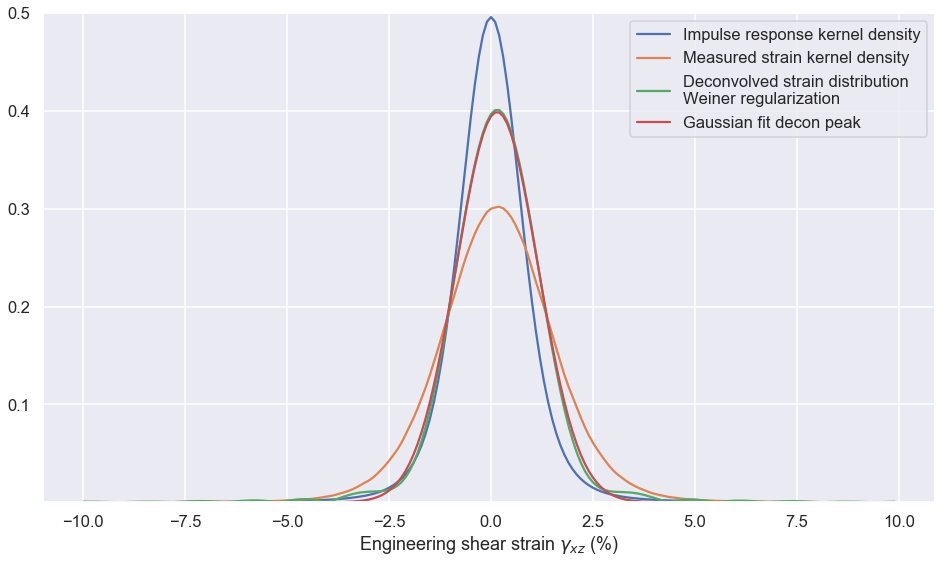

In [606]:
f,ax = plt.subplots(figsize=(16,9))
#ax.set(yscale='log')
#g = sns.distplot(impulse_hist, kde=False, norm_hist = True, label='`Impulse`: Strain from particle locating \n uncertainties')
g = sns.lineplot(y=impulse_kde_sym_pmf, x= t, label = "Impulse response kernel density")
#sns.distplot(measurement_hist, kde=False, norm_hist = True, label='Measured strain histogram')
sns.lineplot(y=measurement_pmf, x= t, label = "Measured strain kernel density")
sns.lineplot(y=np.abs(signal_decon),x=fftshift(t),label='Deconvolved strain distribution \nWeiner regularization')
sns.lineplot(y=scipy.stats.norm(loc=0.150,scale=1).pdf(t), x=t,label='Gaussian fit decon peak')
g.set(ylim=(10**-6,0.5))
g.set_xlabel('Engineering shear strain $\gamma_{xz}$ (%)')

plt.legend()

#sns.lineplot(y=np.real(signal_decon),x=fftshift(t),label='True strain distribution \n Weiner regularized decon signal')
describe_pmf(np.abs(signal_decon),fftshift(t))

In [607]:
g.figure.savefig(figPath + '/deconComparison_lin.pdf', dpi=300)

# SCRATCH

In [97]:
print(describe_pmf(measurement_pmf,t))
print(describe_pmf(impulse_pmf,t))
#print(describe_pmf(np.abs(signal_decon),t))
print(describe_pmf(np.abs(signal_decon),fftshift(t)))
#print(describe_pmf(np.real(signal_decon),fftshift(t)))

{'norm': 0.9999931833613157, 'mean': 0.15104425243108424, 'standard deviation': 1.460300780495777, 'skew': 3.30634012009131e-07, 'kurtosis': 4.640885710660815}
{'norm': 0.9999938236578966, 'mean': 0.0014457714858111318, 'standard deviation': 1.026730232412852, 'skew': 8.250151992873918e-09, 'kurtosis': 11.205424648812897}
{'norm': 1.0054157541221451, 'mean': 0.1491773608424656, 'standard deviation': 1.1564321053177975, 'skew': -0.0005223979185888915, 'kurtosis': 9.772295321562215}


In [176]:
tmp = np.sqrt(1.460300780495777**2 - 1.026730232412852**2) 

In [65]:
# let just check if these formula are working...
delta = 0.1
t = np.arange(-10,10,delta)
normal_kde = scipy.stats.norm(loc=3.2,scale=0.7)
normal_pmf = normal_kde.pdf(t)

mean_pmf(normal_pmf,t)
std_pmf(normal_pmf,t)

0.7000000000000001

In [72]:
print(std_pmf(measurement_pmf,t))
print(np.std(measurement_hist))

1.460300780495777
1.4575853105769416


In [75]:
print(kurtosis_pmf(measurement_pmf,t))
print(scipy.stats.kurtosis(measurement_hist,fisher=False))
print(scipy.stats.kurtosis(measurement_hist,fisher=False))

4.640885710660815
4.665742356830676
4.6657274602033345


In [71]:
print(skew_pmf(measurement_pmf,t))
print(scipy.stats.skew(measurement_hist))

3.30634012009131e-07
-0.008875095976325255


In [83]:
print(checkNorm(np.real(signal_decon),fftshift(t)))
print(mean_pmf(np.real(signal_decon),fftshift(t)))
print(std_pmf(np.real(signal_decon),fftshift(t)))
print(skew_pmf(np.real(signal_decon),fftshift(t)))
print(kurtosis_pmf(np.real(signal_decon),fftshift(t)))

0.9999993596994576
0.14802594789316018
1.0412919095959499
8.39468180073577e-08
2.552060336890948


In [11]:
len(sedPos.xs(0,level='frame').dropna().index)

963752

/Users/zsolt/.conda/envs/TractionRheoscopy/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='(0,1)', ylabel='Density'>

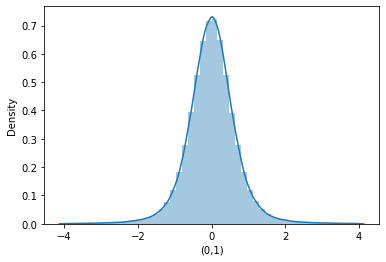

In [23]:
tmp = resampled_traj.xs('exz',level='values')['(0,1)']
sns.distplot(200*tmp[(tmp < 4/200) & (tmp > -4/200)])